### Prepare design matrix (dummy variables)

In [12]:
import formulaic
import pandas as pd
import numpy as np
import pandas as pd

data = pd.read_csv("../../single_parameter/combined_data/statistics.csv")

# Convert each module to a seperate column (no global intercept)
model_formula = 'Coverage ~ 0 + C(TargetModule)'
design_matrix = formulaic.model_matrix(model_formula, data=data)

design_matrix.rhs.iloc[:, :]

,C(TargetModule)[T.codetiming._timer],C(TargetModule)[T.flutils.decorators],C(TargetModule)[T.flutils.namedtupleutils],C(TargetModule)[T.flutils.packages],C(TargetModule)[T.flutils.setuputils.cmd],C(TargetModule)[T.httpie.output.formatters.headers],C(TargetModule)[T.httpie.plugins.base],C(TargetModule)[T.mimesis.builtins.da],C(TargetModule)[T.py_backwards.transformers.base],C(TargetModule)[T.py_backwards.transformers.dict_unpacking],...,C(TargetModule)[T.pymonet.maybe],C(TargetModule)[T.pymonet.validation],C(TargetModule)[T.pypara.accounting.journaling],C(TargetModule)[T.pytutils.lazy.lazy_import],C(TargetModule)[T.pytutils.python],C(TargetModule)[T.sanic.config],C(TargetModule)[T.sanic.helpers],C(TargetModule)[T.sanic.mixins.signals],C(TargetModule)[T.thonny.plugins.pgzero_frontend],C(TargetModule)[T.typesystem.tokenize.positional_validation]
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9355,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
9356,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
9357,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
9358,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


### Run Model

In [13]:
import pymc as pm

with pm.Model() as model:
    # Global Intercept and standard deviation for Modules
    a_bar = pm.Normal('a_bar', mu=0, sigma=1.5)
    sigma = pm.Exponential('sigma', 1.5)
    
    # Module specific intercept
    a_m = pm.Normal('a_m', mu=a_bar, sigma=sigma, shape=design_matrix.rhs.shape[1])
    
    # Activate the correct module dummy variable
    logit_p = pm.math.dot(design_matrix.rhs, a_m)
    
    # Link function (logit), unbounded to (0,1) probability
    p = pm.Deterministic('p', pm.math.invlogit(logit_p))
    
    # Beta distribution likelihood 
    theta = pm.Uniform('theta', 10, 200) # Disperion parameter
    Y_obs = pm.Beta('Y_obs', alpha=p*theta, beta=(1-p)*theta, observed=design_matrix.lhs['Coverage'])
    
    # Sample from the model and compute log likelihood (for information criterion)
    trace = pm.sample(1000, chains=4, return_inferencedata=True, progressbar=True)
    log_lik = pm.compute_log_likelihood(trace)

print("Model building complete.")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_bar, sigma, a_m, theta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.


Output()

Model building complete.


### Save Trace

In [14]:
import arviz as az
#posterior_dict = {
#    'a_m': trace.posterior['a_m'].values,
#    'a_bar': trace.posterior['a_bar'].values,
#    'sigma': trace.posterior['sigma'].values,
#    'theta': trace.posterior['theta'].values,
#}

#infdata = az.from_dict(posterior=posterior_dict)

az.to_netcdf(trace, "model_1_trace.nc")

'model_1_trace.nc'

In [30]:
az.loo(az.from_netcdf("model_1_trace.nc"))


Computed from 4000 posterior samples and 9360 observations log-likelihood matrix.

         Estimate       SE
elpd_loo 13377.17   233.34
p_loo       34.54        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     9360  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

# Prior Predictive Check


Sampling: [a_bar, a_m, sigma, theta]


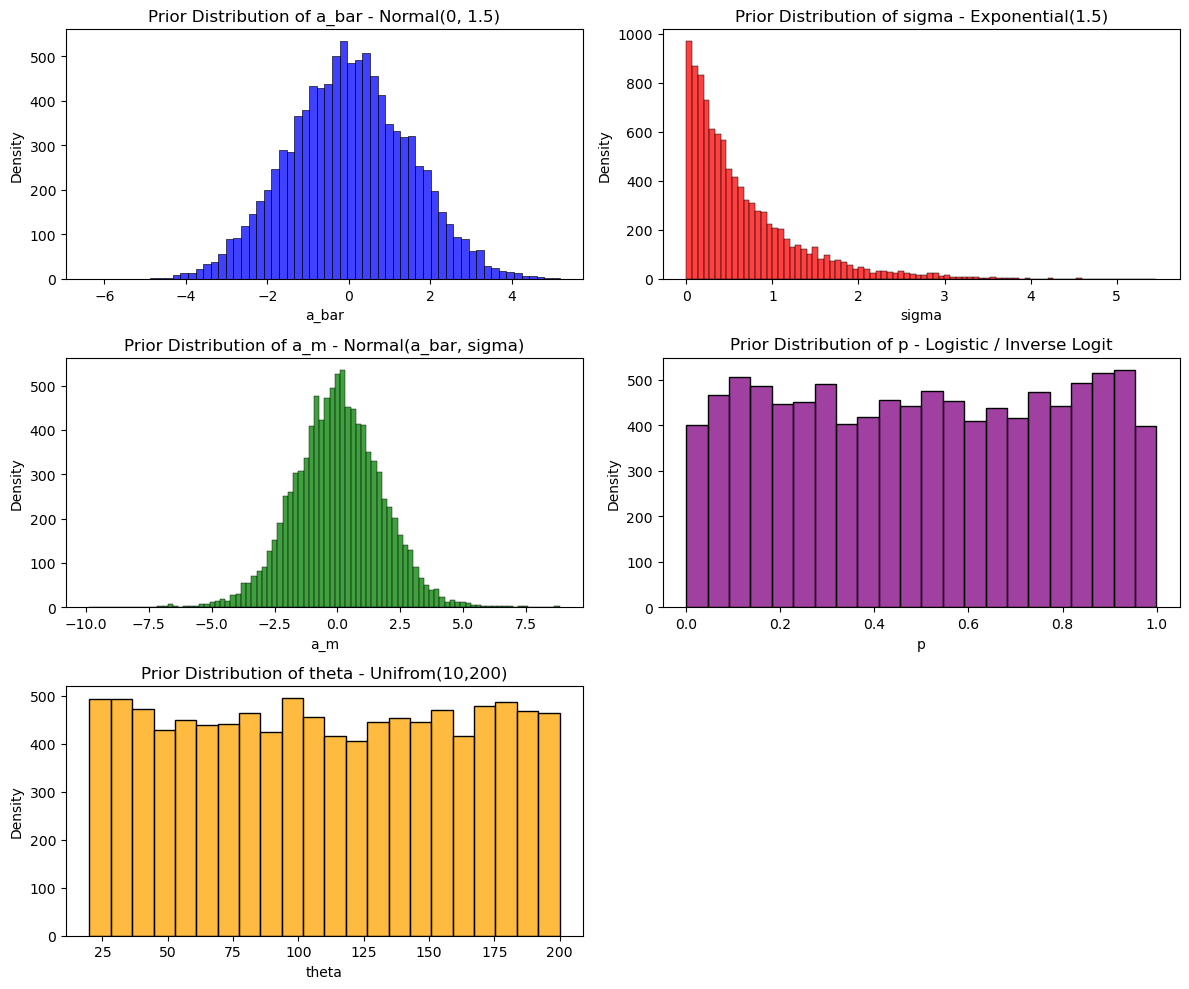

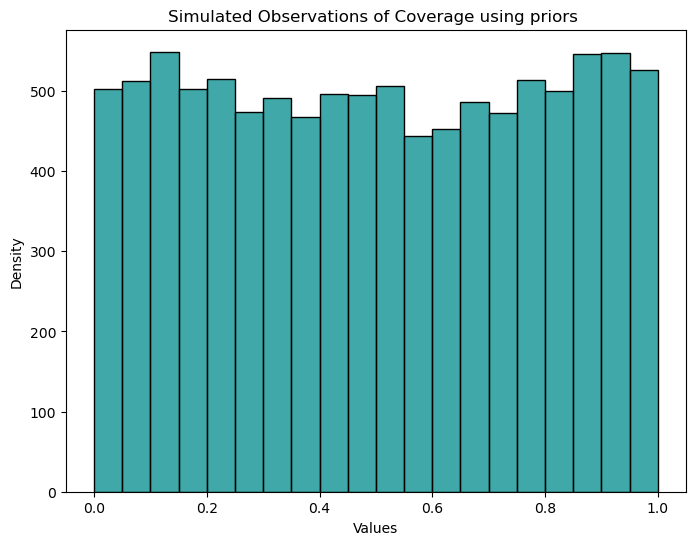

In [9]:
import pymc as pm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

with pm.Model() as model:
     # Global Intercept and standard deviation
    a_bar = pm.Normal('a_bar', mu=0, sigma=1.5)
    sigma = pm.Exponential('sigma', 1.5)
    
    # Module specific intercept
    a_m = pm.Normal('a_m', mu=a_bar, sigma=sigma)
    
    # Link function (logit), unbounded to (0,1) probability
    p = pm.Deterministic('p', pm.math.invlogit(a_m))

    # Beta distribution likelihood 
    theta = pm.Uniform('theta', 20, 200)
    
    # Sample Priors
    idata = pm.sample_prior_predictive(samples=10000)


# Fetch and flatten priors
prior_a_bar = idata.prior['a_bar'].values.flatten()
prior_sigma = idata.prior['sigma'].values.flatten()
prior_a_m = idata.prior['a_m'].values.flatten()
prior_p = idata.prior['p'].values.flatten()
prior_theta = idata.prior['theta'].values.flatten()


# Sample one data point from each combination of priors
simulated_observations = np.random.beta(a=prior_p * prior_theta, b=(1 - prior_p) * prior_theta)



plt.figure(figsize=(12, 10))

# a_bar
plt.subplot(3, 2, 1)
sns.histplot(prior_a_bar, color='blue')
plt.title('Prior Distribution of a_bar - Normal(0, 1.5)')
plt.xlabel('a_bar')
plt.ylabel('Density')

# sigma
plt.subplot(3, 2, 2)
sns.histplot(prior_sigma, color='red')
plt.title('Prior Distribution of sigma - Exponential(1.5)')
plt.xlabel('sigma')
plt.ylabel('Density')

# a_m
plt.subplot(3, 2, 3)
sns.histplot(prior_a_m, color='green')
plt.title('Prior Distribution of a_m - Normal(a_bar, sigma)')
plt.xlabel('a_m')
plt.ylabel('Density')

# p
plt.subplot(3, 2, 4)
sns.histplot(prior_p, color='purple')
plt.title('Prior Distribution of p - Logistic / Inverse Logit')
plt.xlabel('p')
plt.ylabel('Density')

# theta
plt.subplot(3, 2, 5)
sns.histplot(prior_theta, color='orange')
plt.title('Prior Distribution of theta - Unifrom(10,200)')
plt.xlabel('theta')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

# Predicated observations
plt.figure(figsize=(8, 6))
sns.histplot(simulated_observations, bins=np.arange(0, 1.05, 0.05), color='darkcyan')
plt.title('Simulated Observations of Coverage using priors ')
plt.xlabel('Values')
plt.ylabel('Density')
plt.show()